This notebook compiles the training and performance of the model used in the report, with the optimal parameters selected via our ablation studies. It also showcases the grid search used to obtain the parameter values for the LinearSVC model.

In [1]:
from projectFunctions import formatDataset
import os
import time

# Define file paths to training/testing set data
trainDataset = './ExampleSets/INRIAFullDataset/INRIAFullTrain.tar.gz'
testDataset = './ExampleSets/INRIAFullDataset/INRIAFullTest.tar.gz'

# Make folder to save graphs to if it doesn't exist already
graphFolder = './AblationImages'
if not os.path.isdir(graphFolder): os.mkdir(graphFolder)

# Get HOG features with optimal parameters 
# (randomSeed has been set for reproducibility)
print('Calculating HOG features...')
modelStartTime = time.time()
_, modelTrainFeatures, modelTrainLabels = formatDataset(
    trainDataset, 
    numberOfBins = 12, 
    blockDimensions = (2, 2), 
    normalisationTechnique = 'L2-Hys', 
    deleteDir = True, 
    randomSeed = 48
)
_, modelTestFeatures, modelTestLabels = formatDataset(
    testDataset, 
    numberOfBins = 12, 
    blockDimensions = (2, 2), 
    normalisationTechnique = 'L2-Hys', 
    deleteDir = True, 
    randomSeed = 48
)
print((
    'HOG features calculated; elapsed time = '
    f'{time.time() - modelStartTime:.2f} seconds'
))

Calculating HOG features...
HOG features calculated; elapsed time = 15.06 seconds


In [2]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Create and train SVM model, setting random_state for reproducibility
print('Training LinearSVC model...')
modelFitTime = time.time()
modelSVM = LinearSVC(
    penalty='l2', loss='squared_hinge', C=0.01, random_state = 48
)
modelSVM.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Training complete; elapsed time = '
    f'{time.time() - modelFitTime:.2f} seconds\n'
))

# Get predictions and decision function on the testing set
modelPredicts = modelSVM.predict(modelTestFeatures)
modelDecisions = modelSVM.decision_function(modelTestFeatures)

# Calculate performance metrics with predictions/decisions
modelAccuracy = accuracy_score(modelTestLabels, modelPredicts)
modelPrecision = precision_score(modelTestLabels, modelPredicts)
modelRecall = recall_score(modelTestLabels, modelPredicts)
modelF1 = f1_score(modelTestLabels, modelPredicts)
modelAUC = roc_auc_score(modelTestLabels, modelDecisions)

# Compile performance metrics into pandas Series
modelScores = pd.Series(
    (modelAccuracy, modelPrecision, modelRecall, modelF1, modelAUC), 
    index = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
)

# Display DataFrame with caption
print('Performance Scores of HOG Features on INRIA Testing Dataset')
modelScores

Training LinearSVC model...
Training complete; elapsed time = 0.45 seconds

Performance Scores of HOG Features on INRIA Testing Dataset


Accuracy     0.975556
Precision    0.979821
Recall       0.971111
F1 Score     0.975446
AUC          0.997491
dtype: float64

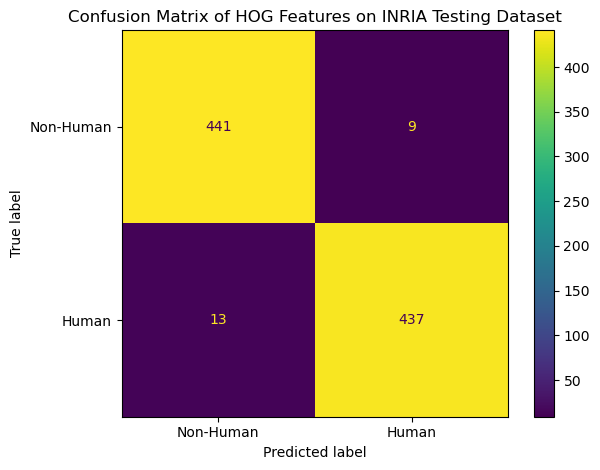

In [3]:
# Import confusion matrix and matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix for final model
ConfusionMatrixDisplay.from_predictions(
    modelTestLabels, modelPredicts, display_labels = ['Non-Human', 'Human']
)

plt.title('Confusion Matrix of HOG Features on INRIA Testing Dataset')
plt.tight_layout()
plt.savefig(os.path.join(graphFolder, 'final_matrix.png'))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

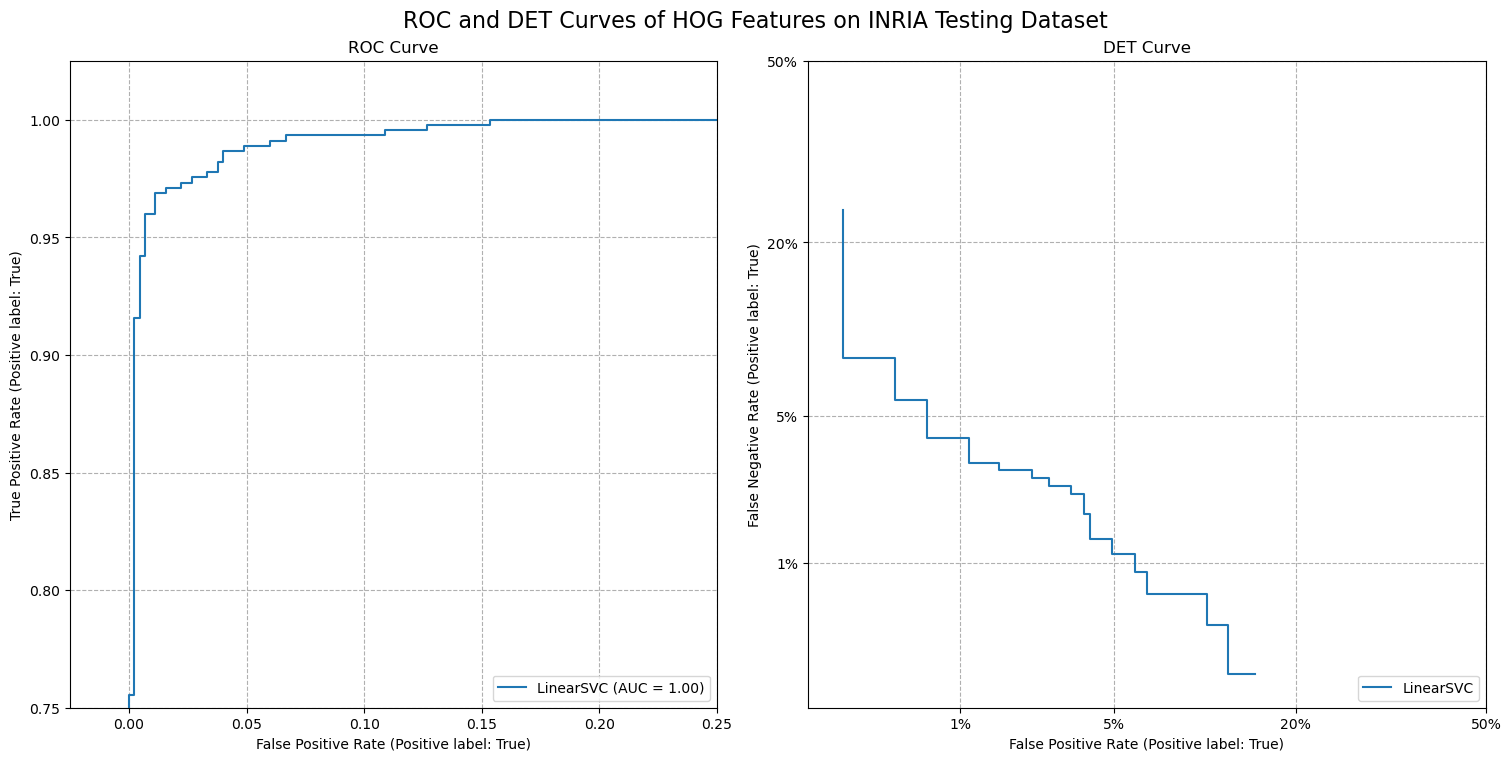

In [4]:
# Import ROC and DET curve functions
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Initialise curve figure
curveFigure, (rocAxes, detAxes) = plt.subplots(
    1, 2, figsize = (15,7.5), constrained_layout = True
)

# Generate ROC and DET curves for the model
RocCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=rocAxes
)
DetCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=detAxes
)
rocAxes.grid(linestyle = "--") 
detAxes.grid(linestyle = "--") 

# Add titles and adjust limits for each axis
rocAxes.set_title('ROC Curve')
rocAxes.set_xlim([-0.025, 0.25])
rocAxes.set_ylim([0.75, 1.025])

detAxes.set_title('DET Curve')
detAxes.set_xlim([-3, 0])
detAxes.set_ylim([-3, 0])

# Set figure title
curveFigure.suptitle(
    'ROC and DET Curves of HOG Features on INRIA Testing Dataset', fontsize = 16
)

# Save curves as image
plt.savefig(os.path.join(graphFolder, 'final_curves.png'))

# Display ROC and DET curves
plt.show

In [5]:
# Import grid search class
from sklearn.model_selection import GridSearchCV

# Note: this grid search takes several minutes to run. Uncomment it if you wish to run it again
'''
# Define parameters to test with the grid search
modelParameters = [
    {
        'penalty': ['l1', 'l2'],
        'loss': ['squared_hinge'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ]
    }, {
        'penalty': ['l2'],
        'loss': ['hinge'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ]
    }
        
]

# Define and run the grid search
gridSVM = LinearSVC(max_iter = 100000, random_state = 48)
modelSearch = GridSearchCV(
    gridSVM, modelParameters, cv = 5, scoring = 'f1'
)
print('Running grid search...')
gridStartTime = time.time()
modelSearch.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Grid search complete; elapsed time = '
    f'{time.time() - gridStartTime:.2f} seconds'
))

# Display the best parameters
print('Highest F1 scoring parameters for the SVM classifier:')
for param, value in modelSearch.best_params_.items(): print(f'{param}: {value}')

# Display best 15 results, filtering to relevant columns
modelResults = pd.DataFrame(modelSearch.cv_results_).sort_values(
    by = ['mean_test_score'], ascending = [False]
)
modelResults[[
    'rank_test_score', 'param_penalty', 'param_loss',
    'param_C', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 
]].head(15).style.hide(axis = 'index').set_caption(
    'Top 15 SVM Parameter Combinations on INRIA Training Dataset by F1 Score'
)
'''

Running grid search...
Grid search complete; elapsed time = 536.88 seconds
Highest F1 scoring parameters for the SVM classifier:
C: 0.01
loss: hinge
penalty: l2


rank_test_score,param_penalty,param_loss,param_C,mean_test_score,mean_fit_time,mean_score_time
1,l2,hinge,0.010000,0.966865,0.399765,0.006469
2,l2,squared_hinge,0.010000,0.966326,0.400528,0.002191
3,l2,hinge,0.007500,0.966070,0.384261,0.004195
4,l2,squared_hinge,0.007500,0.966063,0.383868,0.001704
5,l2,squared_hinge,0.005000,0.965803,0.362430,0.001595
6,l2,hinge,0.025000,0.965662,0.567978,0.007177
7,l2,squared_hinge,0.025000,0.964322,0.485401,0.001696
8,l2,squared_hinge,0.002500,0.963386,0.337288,0.001628
9,l1,squared_hinge,0.250000,0.963106,6.277440,0.002931
10,l2,hinge,0.005000,0.962489,0.315964,0.002284
